# Analysing the Distributions of Edit-Session Lengths
<h3>(by platform; for visual-editor powered interfaces)</h3>
<hr>

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**<br>
**Last updated on 18 July 2023**

[TASK: T338634](https://phabricator.wikimedia.org/T338634)

# Contents

1. [Introduction](#Introduction)
2. [Summary](#Summary)
3. [Data Gathering](#Data-Gathering)
4. [Histograms](#Histograms)
5. [Appendix](#Appendix)

# Introduction
The purpose of this analysis is to help the Editing team understand the distribution of edit session lengths for visual-editor powered editing interfaces, across platforms. The findings are intended help the editing team inform their decision to for how long should the edit stash [TTL](https://en.wikipedia.org/wiki/Time_to_live) be set to ([T320536](https://phabricator.wikimedia.org/T320536)).

The learning objectives are to understand the distributions of edit sessions lengths (by platform):
- for edits that were initiated and successfully saved
- for edit that were initated and aborted

# Summary

The data was gathered from the event logs of [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/current.yaml). 90-days of [unsanitized event data](https://wikitech.wikimedia.org/wiki/Analytics/Event_Sanitization) preceding 13 July 2023 was considered for the analysis. The length of an edit session is calculated as a difference between the max and min of `client_dt` for a given `editing_session_id`. The data was analysed by desktop and mobile (phone) platform.

There were sessions with 0-duration. Among successfully saved edits, the number of 0-duration sessions is insignificant (0.01% of ~3.6 million sessions) - inclusion or exclusion of these don't have any effect on the distributions until the 99th percentile. However, among aborted edits, the number of 0-duration sessions are 0.6% of ~16 million sessions, and including them effects the distributions beyond the 75th percentile by bringing down the session lengths. For the analysis, 0-duration sessions were not considered, however, they are included in the [appendix](#Appendix) for reference.

In [23]:
warnings.filterwarnings('ignore')

print(bold, 'Time to save (excl. 0-duration sessions)', end)
display_h({
    'Desktop devices': quantiles(completed, 'desktop', 'exclude'),
    'Mobile devices': quantiles(completed, 'phone', 'exclude')
})

 Time to save (excl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,16
25th,32
50th,83
75th,272
90th,881
99th,6915
,time (in seconds)
percentile,
10th,17


In [24]:
warnings.filterwarnings('ignore')

print(bold, 'Time to abort (excl. 0-duration sessions)', end)
display_h({
    'Desktop devices': quantiles(aborted, 'desktop', 'exclude'),
    'Mobile devices': quantiles(aborted, 'phone', 'exclude')
})

 Time to abort (excl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,2
25th,3
50th,6
75th,15
90th,80
99th,4401
,time (in seconds)
percentile,
10th,2


# Data-Gathering

## imports

In [1]:
import pandas as pd
import numpy as np
import wmfdata as wmf

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

from datetime import timedelta, datetime
import warnings

from IPython.display import display_html

In [2]:
pd.options.display.max_columns = None
bold = '\033[1m'
end = '\033[0m'

## spark_session

In [3]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [ ]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

In [5]:
# ig_warn()
# spark_session = wmf.spark.create_session(type='yarn-large')
spark_session

In [6]:
spark_session.sparkContext.setLogLevel("ERROR")

## query

In [24]:
%%time

query = """
WITH
    sessions AS (
        SELECT
            event.editing_session_id AS session_id,
            event.platform,
            event.page_ns,
            event.user_class,
            SUM(CAST(event.action = 'init' AS INT)) AS init_count,
            SUM(CAST(event.action = 'saveSuccess' AS INT)) AS save_success_count,
            SUM(CAST(event.action = 'abort' AS INT)) AS abort_count,
            MAX(client_dt) AS max_ts,
            MIN(client_dt) AS min_ts
        FROM
            event.editattemptstep
        WHERE
            event.editor_interface = 'visualeditor' AND
            NOT event.is_oversample AND
            year = {YEAR} AND month = {MONTH}
        GROUP BY
            event.editing_session_id,
            event.platform,
            event.page_ns,
            event.user_class
    )

SELECT *
FROM sessions
WHERE
    init_count > 0 AND
    ((save_success_count > 0) OR 
     (abort_count > 0))
"""

# query month-wise as querying all month is leading to Spark OutOfMemory Error
sessions = pd.DataFrame()
end_time = datetime.now() - timedelta(days=1)
start_time = datetime.now() - timedelta(days=90)

for month in pd.period_range(str(start_time.date()), str(end_time.date()), freq='M'):
    monthly_records = wmf.spark.run(query.format(YEAR=month.year, MONTH=month.month))
    sessions = pd.concat([sessions, monthly_records], ignore_index=True)
    
sessions.shape

CPU times: user 2min 12s, sys: 30.2 s, total: 2min 42s
Wall time: 4min 27s


(20033867, 9)

In [25]:
# set explicit classes, as null values (i.e. user) are not displayed in Pandas count outputs

def uclass_sort(user):
    if user == 'IP':
        return 'anon'
    elif user == 'bot':
        return 'bot'
    else:
        return 'user'
    
sessions['user_class'] = sessions['user_class'].apply(lambda x: uclass_sort(x))
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20033867 entries, 0 to 20033866
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   session_id          object
 1   platform            object
 2   page_ns             int64 
 3   user_class          object
 4   init_count          int64 
 5   save_success_count  int64 
 6   abort_count         int64 
 7   max_ts              object
 8   min_ts              object
dtypes: int64(4), object(5)
memory usage: 1.3+ GB


In [ ]:
# save to parquet
parquet_file = 've_sessions_2023.parquet'
sessions.to_parquet(parquet_file, index=False)

In [4]:
sessions = pd.read_parquet(parquet_file)

In [ ]:
# format data types
sessions = (
    sessions
    .assign(
        min_ts=pd.to_datetime(sessions['min_ts'], utc=True),
        max_ts=pd.to_datetime(sessions['max_ts'], utc=True),
        platform=pd.Categorical(sessions['platform']),
        user_class=pd.Categorical(sessions['user_class']))
    .assign(
        duration=lambda df: round((df["max_ts"] - df["min_ts"]).dt.total_seconds()).astype(int)))

sessions.head(3)

In [6]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20033867 entries, 0 to 20033866
Data columns (total 10 columns):
 #   Column              Dtype              
---  ------              -----              
 0   session_id          object             
 1   platform            category           
 2   page_ns             int64              
 3   user_class          category           
 4   init_count          int64              
 5   save_success_count  int64              
 6   abort_count         int64              
 7   max_ts              datetime64[ns, UTC]
 8   min_ts              datetime64[ns, UTC]
 9   duration            int64              
dtypes: category(2), datetime64[ns, UTC](2), int64(5), object(1)
memory usage: 1.2+ GB


In [7]:
# considering sessions only with either success or abort event, but not both
# sessions with both success and abort events may be erroneous events that need further analysis
completed = sessions.query("""(save_success_count >= 1) & (abort_count == 0)""")
print(f'successfuly completed sessions: {completed.shape[0]}')

aborted = sessions.query("""(abort_count >= 1) & (save_success_count == 0)""")
print(f'aborted sessions: {aborted.shape[0]}')

successfuly completed sessions: 3696218
aborted sessions: 16208443


Note: A summary of erroneous events such as sessions having both save and abort logs, having no inits, having no outcomes etc. has been provided in `data_qa.ipynb` notebook (in same repo)

## explore data

### successfully completed sessions
<u>Summary:</u> Sessions with zero duration form a insignificant part of the overall number of successfully saved sessions (0.01%). Since excluding them will not result any substantial changes in the time to save distributions, we will be excluding them while plotting the histograms (for consistency with the aborted sessions).

In [44]:
print(bold, 'percentage of zero duration sessions (of all completed sessions)', end)
print(f'{round(completed.query("""duration == 0""").shape[0] / completed.shape[0] * 100, 2)}% (of {completed.shape[0]} completed sessions)')

 percentage of zero duration sessions (of all completed sessions) 
0.01% (of 3696218 completed sessions)


In [45]:
print(bold, 'median time to save for completed sessions, by platform', end)
completed.groupby('platform')['duration'].apply(np.median)

 median time to save for completed sessions, by platform 


platform
desktop    83.0
phone      62.0
Name: duration, dtype: float64

In [46]:
print(bold, 'median time to save for completed sessions, by platform (excluding zero duration sessions)', end)
completed.query("""duration > 0""").groupby('platform')['duration'].apply(np.median)

 median time to save for completed sessions, by platform (excluding zero duration sessions) 


platform
desktop    83.0
phone      62.0
Name: duration, dtype: float64

In [26]:
print(bold, 'frequency of sessions (saved) with duration as zero by platform and userclass', end)
completed.query("""duration == 0""")[['platform', 'user_class']].value_counts()

 frequency of sessions (saved) with duration as zero by platform and userclass 


platform  user_class
desktop   user          186
phone     user           95
desktop   anon           10
phone     anon            3
dtype: int64

### aborted sessions
<u>Summary</u> Unlike for completed sessions, number of zero durations among the aborted sessions are not non-trivial. The median shifts up by a second when zero are excluded (10% change). For plotting the histograms, we will be excluding the zero duration sessions, so as not to skew the results to imply less time taken.

In [48]:
print(bold, 'percentage of zero duration sessions (of all aborted sessions)', end)
print(f'{round(aborted.query("""duration == 0""").shape[0] / aborted.shape[0] * 100, 2)}% (of {aborted.shape[0]} aborted sessions)')

 percentage of zero duration sessions (of all aborted sessions) 
0.64% (of 16208443 aborted sessions)


In [49]:
print(bold, 'median time to abort, by platform', end)
aborted.groupby('platform')['duration'].apply(np.median)

 median time to abort, by platform 


platform
desktop     6.0
phone      10.0
Name: duration, dtype: float64

In [50]:
print(bold, 'median time to abort, by platform (excluding zero duration sessions)', end)
aborted.query("""duration != 0""").groupby('platform')['duration'].apply(np.median)

 median time to abort, by platform (excluding zero duration sessions) 


platform
desktop     6.0
phone      11.0
Name: duration, dtype: float64

In [27]:
print(bold, 'frequency of sessions (aborted) with duration as zero by platform and userclass', end)
aborted.query("""duration == 0""")[['platform', 'user_class']].value_counts()

 frequency of sessions (aborted) with duration as zero by platform and userclass 


platform  user_class
desktop   anon          81153
phone     anon          13364
desktop   user           6800
phone     user           3049
dtype: int64

# Histograms

In [29]:
# the plotting function has been built upon a similar analysis from 2018
# https://github.com/wikimedia-research/2018-08-Editing-metrics-snapshots/blob/master/analysis.ipynb

def generate_hist(ax, source_frame, title, 
                  col='duration', 
                  ylabel='number of sessions', 
                  legend_loc='upper right', 
                  anchor_pos=(1.5, 1), 
                  treat_zeros='exclude'):
    
    frame = source_frame.copy()
    if treat_zeros == 'exclude':
        frame = frame[frame[col] > 0]
    elif treat_zeros == 'replace':
        frame[col] = frame[col].replace(0, 1)
    else:
        pass
    
    ax = sns.histplot(data=frame, 
                      x=col, 
                      log_scale=True,
                      bins = np.linspace(0, 4, 40), 
                      element='step',
                      color='#DAA520'
                 )
    
    def td_str(s):
        return str(timedelta(seconds=int(s)))
    
    x_ticks = [1, 10, 60, 10*60, 60*60]
    duration_ticks = FixedLocator(x_ticks)
    duration_fmt = FuncFormatter(lambda x, pos: td_str(x))
    
    lines = [
        ("10th percentile ({})", frame[col].quantile(0.1), "#FF0000"),
        ("50th percentile ({})", frame[col].median(), "#6B8E23"),
        ("90th percentile ({})", frame[col].quantile(0.9), "#0000FF")
    ]
    
    for label, pos, color in lines:
        ax.axvline(x=pos, color=color, label=label.format(td_str(pos)))
    
    ax.xaxis.set_major_locator(duration_ticks)
    ax.xaxis.set_major_formatter(duration_fmt)
    
    ax.set_title(title)
    ax.set_xlabel('time to save [%H:%M:%S] (log scale)')
    ax.set_ylabel(ylabel)
    
    ax.legend(loc=legend_loc, bbox_to_anchor=anchor_pos)

### successfully saved sessions

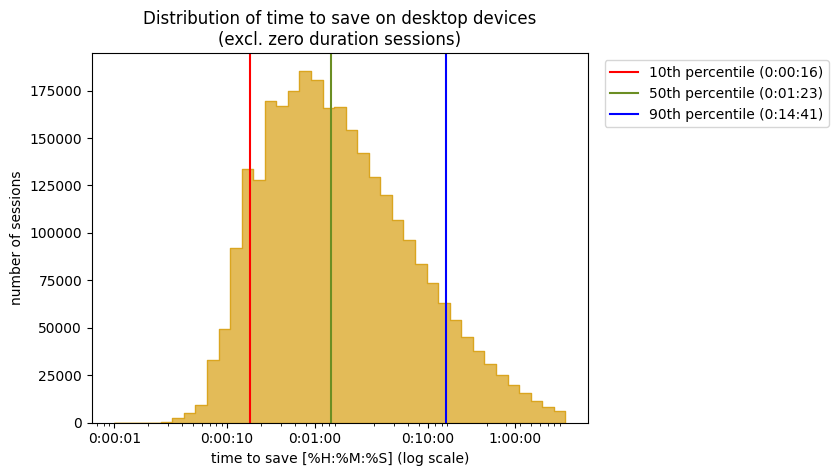

In [32]:
fig, ax = plt.subplots()
generate_hist(ax, completed.query("""platform == 'desktop'"""), 
              title='Distribution of time to save on desktop devices\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

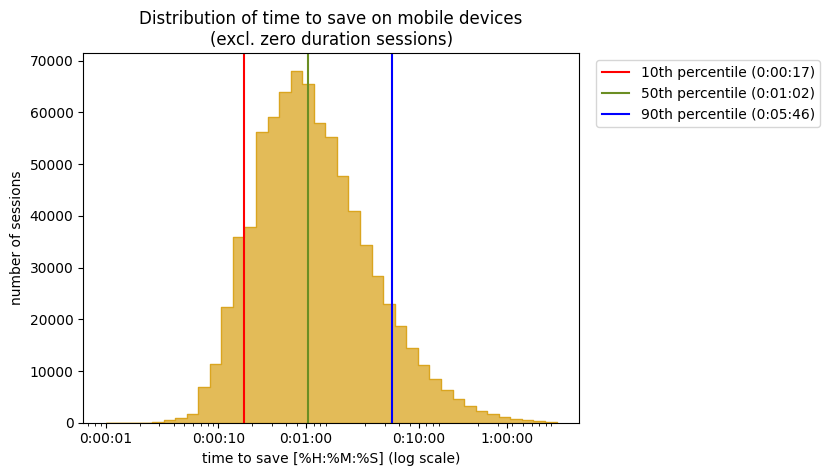

In [31]:
fig, ax = plt.subplots()
generate_hist(ax, completed.query("""platform == 'phone'"""), 
              title='Distribution of time to save on mobile devices\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

### aborted sessions

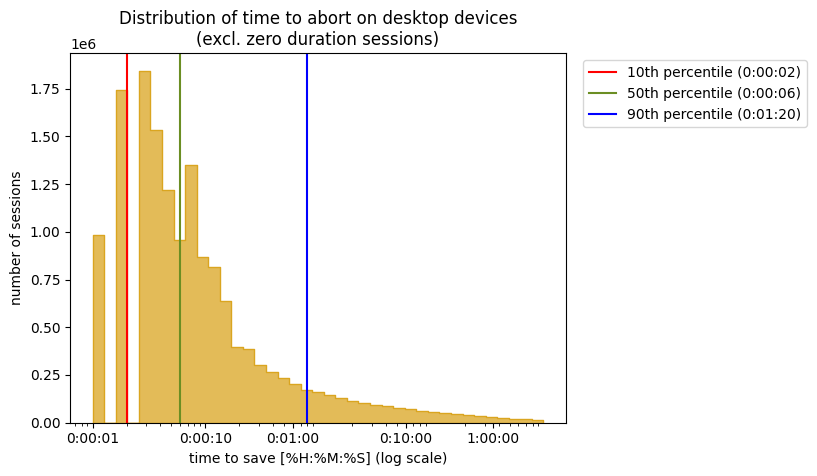

In [72]:
fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""platform == 'desktop'"""), 
              title='Distribution of time to abort on desktop devices\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

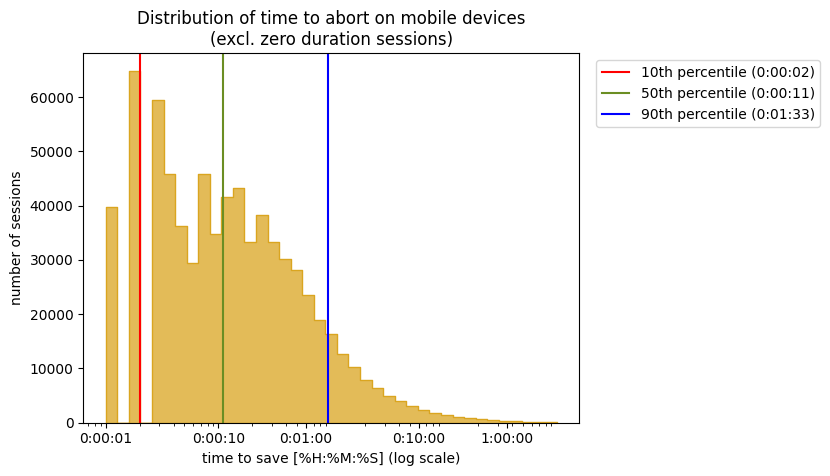

In [71]:
fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""platform == 'phone'"""), 
              title='Distribution of time to abort on mobile devices\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

# Appendix

In [19]:
def quantiles(source_frame, platform, treat_zeros, col='duration'):
    frame = source_frame.query("""platform == @platform""")
    
    if treat_zeros == 'exclude':
        frame = frame[frame[col] > 0]
    elif treat_zeros == 'replace':
        frame[col] = frame[col].replace(0, 1)
    else:
        pass
    
    qdict = {
        '10th': frame[col].quantile(0.1),
        '25th': frame[col].quantile(0.25),
        '50th': frame[col].quantile(0.5),
        '75th': frame[col].quantile(0.75),
        '90th': frame[col].quantile(0.9),
        '99th': frame[col].quantile(0.99)
    }
    
    df = pd.DataFrame(qdict.values(),
                      index=qdict.keys(),
                      columns=['time (in seconds)'])
    
    df = df.astype({'time (in seconds)': int})
    df.index.name = 'percentile'
    
    return df

In [20]:
def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

In [33]:
warnings.filterwarnings('ignore')

print(bold, 'Time to save (incl. 0-duration sessions)', end)
display_h({
    'Desktop devices': quantiles(completed, 'desktop', None),
    'Mobile devices': quantiles(completed, 'phone', None)
})

 Time to save (incl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,16
25th,32
50th,83
75th,272
90th,881
99th,6915
,time (in seconds)
percentile,
10th,17


In [34]:
warnings.filterwarnings('ignore')

print(bold, 'Time to save (excl. 0-duration sessions)', end)
display_h({
    'Desktop devices': quantiles(aborted, 'desktop', None),
    'Mobile devices': quantiles(aborted, 'phone', None)
})

 Time to save (excl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,2
25th,3
50th,6
75th,15
90th,79
99th,4367
,time (in seconds)
percentile,
10th,2
